In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
# authenticate
auth.authenticate_user()

In [ ]:
# Set up environment variables
project_id = 'static-battery-395511'
#project_id = 'supple-voyage-395002'
#project_id = 'my-project-iv-402706'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'


In [ ]:
# Query to fetch hypotension related data from MIMIC-IV (ICU)
icu_glucose_ids = run_query("""
SELECT * FROM `physionet-data.mimiciv_icu.d_items` WHERE LOWER(label) LIKE '%glucose%';
""")
#df
print(icu_glucose_ids)

    itemid                                label                  abbreviation  \
0   220621                      Glucose (serum)               Glucose (serum)   
1   225664  Glucose finger stick (range 70-100)    Glucose FS (range 70 -100)   
2   226537                Glucose (whole blood)         Glucose (whole blood)   
3   228388         Glucose (whole blood) (soft)  Glucose (whole blood) (soft)   
4   228692             Glucose Control - Prophy      Glucose Control - Prophy   
5   227976          Boost Glucose Control (1/4)   Boost Glucose Control (1/4)   
6   227977          Boost Glucose Control (1/2)   Boost Glucose Control (1/2)   
7   227978          Boost Glucose Control (3/4)   Boost Glucose Control (3/4)   
8   227979         Boost Glucose Control (Full)  Boost Glucose Control (Full)   
9   227015                     Glucose_ApacheIV              Glucose_ApacheIV   
10  227016                GlucoseScore_ApacheIV         GlucoseScore_ApacheIV   
11  220395                  

In [ ]:
# Query to fetch hypotension related data from MIMIC-IV (Hosp)
hosp_glucose_ids = run_query("""
SELECT * FROM `physionet-data.mimiciv_hosp.d_labitems` WHERE LOWER(label) LIKE '%glucose%';
""")
#df
print(hosp_glucose_ids)

    itemid                 label                fluid    category
0    50809               Glucose                Blood   Blood Gas
1    52027  Glucose, Whole Blood                Blood   Blood Gas
2    50931               Glucose                Blood   Chemistry
3    52569               Glucose                Blood   Chemistry
4    51941        Glucose, Stool                Stool   Chemistry
5    51084        Glucose, Urine                Urine   Chemistry
6    51981               Glucose                Urine   Chemistry
7    50842      Glucose, Ascites              Ascites   Chemistry
8    51053      Glucose, Pleural              Pleural   Chemistry
9    51022  Glucose, Joint Fluid          Joint Fluid   Chemistry
10   51034   Glucose, Body Fluid     Other Body Fluid   Chemistry
11   51790          Glucose, CSF  Cerebrospinal Fluid   Chemistry
12   51478               Glucose                Urine  Hematology


In [ ]:
# Extract patients' data with glucose and HbA1c measurements meeting specific criteria (ICU)
possible_patients_1 =  run_query("""
WITH chartevents_details AS (
  SELECT chartevents.subject_id, chartevents.hadm_id, chartevents.itemid,
         ARRAY_AGG(chartevents.valuenum) AS valuenums,
         ARRAY_AGG(chartevents.charttime) AS charttimes
  FROM `physionet-data.mimiciv_icu.chartevents` AS chartevents
  WHERE chartevents.itemid IN (220621, 225664, 226537) AND chartevents.valuenum >= 125
  GROUP BY chartevents.subject_id, chartevents.hadm_id, chartevents.itemid
),
condition1 AS (
  SELECT le.subject_id, le.hadm_id, le.itemid,
      ARRAY_AGG(le.valuenum) AS labhba1cvaluenums,
      ARRAY_AGG(le.charttime) AS labhba1ccharttimes
  FROM `physionet-data.mimiciv_hosp.patients` AS p
  INNER JOIN `physionet-data.mimiciv_hosp.labevents` AS le
  ON p.subject_id = le.subject_id
  WHERE
    le.itemid IN (50852)
    AND le.valuenum >= 6.5
  GROUP BY le.subject_id, le.hadm_id, le.itemid
)

SELECT c1.subject_id, COALESCE(ced.hadm_id ,c1.hadm_id) AS hadm_id, ced.itemid AS glucose_itemid, ced.valuenums AS glucose_valuenums, ced.charttimes AS glucose_charttimes,c1.itemid AS hba1c_itemid, c1.labhba1cvaluenums AS hba1cvaluenums, c1.labhba1ccharttimes AS hba1ccharttimes
FROM chartevents_details ced
INNER JOIN condition1 c1
ON c1.subject_id = ced.subject_id AND c1.hadm_id = ced.hadm_id
ORDER BY c1.subject_id;

""")

In [ ]:
# Extract patients' data with glucose and HbA1c measurements meeting specific criteria (Hosp)
possible_patients_2 = run_query("""WITH labevent_details AS (
  SELECT le.subject_id, le.hadm_id, le.itemid,
      ARRAY_AGG(le.valuenum) AS valuenums,
      ARRAY_AGG(le.charttime) AS charttimes
  FROM `physionet-data.mimiciv_hosp.labevents` AS le
  WHERE
    le.itemid IN (50809,50931,52569,52027) -- Glucose
    AND le.valuenum >= 125
  GROUP BY le.subject_id, le.hadm_id, le.itemid
),
condition1 AS (
  SELECT le.subject_id, le.hadm_id, le.itemid,
      ARRAY_AGG(le.valuenum) AS labhba1cvaluenums,
      ARRAY_AGG(le.charttime) AS labhba1ccharttimes
  FROM `physionet-data.mimiciv_hosp.patients` AS p
  INNER JOIN `physionet-data.mimiciv_hosp.labevents` AS le
  ON p.subject_id = le.subject_id
  WHERE
    le.itemid IN (50852)
    AND le.valuenum >= 6.5
  GROUP BY le.subject_id, le.hadm_id, le.itemid
)

SELECT c1.subject_id, COALESCE(led.hadm_id, c1.hadm_id) AS hadm_id, led.itemid AS glucose_itemid, led.valuenums AS glucose_valuenums, led.charttimes AS glucose_charttimes,c1.itemid AS hba1c_itemid, c1.labhba1cvaluenums AS hba1cvaluenums, c1.labhba1ccharttimes AS hba1ccharttimes
FROM labevent_details led
INNER JOIN condition1 c1
ON c1.subject_id = led.subject_id AND c1.hadm_id = led.hadm_id
ORDER BY c1.subject_id;
"""
)

In [ ]:
possible_patients = pd.concat([possible_patients_1, possible_patients_2], ignore_index=True) # Combine the 2 datasets
print(len(possible_patients))
possible_patients = possible_patients.drop_duplicates(subset='subject_id', keep='first') # Remove duplicates and have a cohort list with unique patients
# col_arr = ['glucose_valuenums','glucose_charttimes', 'hba1cvaluenums', 'hba1ccharttimes']
# for col in col_arr:
#   possible_patients[col] = possible_patients[col].apply(lambda x: x[0])
print(len(possible_patients))
print(possible_patients.head())

20895
8136
    subject_id   hadm_id  glucose_itemid  \
0     10005817  20626031          226537   
3     10008454  20291550          226537   
6     10013310  22098926          225664   
9     10014354  22741225          225664   
11    10015860  25085565          225664   

                                    glucose_valuenums  \
0   [192.0, 214.0, 166.0, 134.0, 213.0, 160.0, 160.0]   
3          [173.0, 221.0, 196.0, 144.0, 135.0, 222.0]   
6   [264.0, 204.0, 312.0, 351.0, 347.0, 150.0, 305...   
9                        [208.0, 251.0, 234.0, 188.0]   
11  [229.0, 306.0, 204.0, 311.0, 498.0, 202.0, 215...   

                                   glucose_charttimes  hba1c_itemid  \
0   [2132-12-15T12:04:00.000000, 2132-12-15T10:58:...         50852   
3   [2110-12-02T02:00:00.000000, 2110-12-01T02:00:...         50852   
6   [2153-06-16T00:00:00.000000, 2153-06-11T16:00:...         50852   
9   [2146-10-09T18:00:00.000000, 2146-10-09T08:00:...         50852   
11  [2186-09-16T06:00:00.0

In [ ]:
# Fine the medications patients who have been administered diabeteic medication
medications= run_query("""
SELECT emar.subject_id, emar.hadm_id,
       ARRAY_AGG(emar.medication) AS medications,
       ARRAY_AGG(emar.event_txt) AS events
FROM `physionet-data.mimiciv_hosp.emar` as emar
WHERE LOWER(event_txt) IN ('administered', 'confirmed', 'applied')
AND LOWER(medication) IN (
    'acetohexamide', 'tolazamide', 'chlorpropamide', 'glipizide', 'glyburide',
    'glimepiride', 'repaglinide', 'nateglinide', 'metformin', 'rosiglitazone',
    'pioglitazone', 'troglitazone', 'acarbose', 'miglitol', 'sitagliptin',
    'exenatide', 'alogliptin', 'saxagliptin', 'linagliptin', 'ertugliflozin',
    'dapagliflozin', 'empagliflozin', 'canagliflozin', 'dulaglutide', 'semaglutide',
    'liraglutide', 'lixisenatide', 'colesevelam', 'bromocriptine'
)
GROUP BY emar.subject_id, emar.hadm_id;

""")

In [ ]:
# Combine the results using pandas
print(len(medications))
# combined_data = possible_patients.merge(medications, on=['subject_id', 'hadm_id'], how='left')
combined_data = possible_patients.merge(medications, on=['subject_id', 'hadm_id'], how='left')

print(len(combined_data))
print(combined_data.head())

2523
8136
   subject_id   hadm_id  glucose_itemid  \
0    10005817  20626031          226537   
1    10008454  20291550          226537   
2    10013310  22098926          225664   
3    10014354  22741225          225664   
4    10015860  25085565          225664   

                                   glucose_valuenums  \
0  [192.0, 214.0, 166.0, 134.0, 213.0, 160.0, 160.0]   
1         [173.0, 221.0, 196.0, 144.0, 135.0, 222.0]   
2  [264.0, 204.0, 312.0, 351.0, 347.0, 150.0, 305...   
3                       [208.0, 251.0, 234.0, 188.0]   
4  [229.0, 306.0, 204.0, 311.0, 498.0, 202.0, 215...   

                                  glucose_charttimes  hba1c_itemid  \
0  [2132-12-15T12:04:00.000000, 2132-12-15T10:58:...         50852   
1  [2110-12-02T02:00:00.000000, 2110-12-01T02:00:...         50852   
2  [2153-06-16T00:00:00.000000, 2153-06-11T16:00:...         50852   
3  [2146-10-09T18:00:00.000000, 2146-10-09T08:00:...         50852   
4  [2186-09-16T06:00:00.000000, 2186-09-15T2

In [ ]:
# Obtaining the demographics of the patients
patient_details = run_query("""
SELECT patients.subject_id, patients.gender, patients.anchor_age, admissions.race
FROM `physionet-data.mimiciv_hosp.patients` AS patients
INNER JOIN `physionet-data.mimiciv_hosp.admissions` AS admissions
ON patients.subject_id = admissions.subject_id;
""")

In [ ]:
print(len(patient_details))
patient_details = patient_details.drop_duplicates(subset='subject_id', keep='first')

combined_data = possible_patients.merge(patient_details, on='subject_id', how='left')

print(len(combined_data))
print(combined_data.head())

431231
8136
   subject_id   hadm_id  glucose_itemid  \
0    10005817  20626031          226537   
1    10008454  20291550          226537   
2    10013310  22098926          225664   
3    10014354  22741225          225664   
4    10015860  25085565          225664   

                                   glucose_valuenums  \
0  [192.0, 214.0, 166.0, 134.0, 213.0, 160.0, 160.0]   
1         [173.0, 221.0, 196.0, 144.0, 135.0, 222.0]   
2  [264.0, 204.0, 312.0, 351.0, 347.0, 150.0, 305...   
3                       [208.0, 251.0, 234.0, 188.0]   
4  [229.0, 306.0, 204.0, 311.0, 498.0, 202.0, 215...   

                                  glucose_charttimes  hba1c_itemid  \
0  [2132-12-15T12:04:00.000000, 2132-12-15T10:58:...         50852   
1  [2110-12-02T02:00:00.000000, 2110-12-01T02:00:...         50852   
2  [2153-06-16T00:00:00.000000, 2153-06-11T16:00:...         50852   
3  [2146-10-09T18:00:00.000000, 2146-10-09T08:00:...         50852   
4  [2186-09-16T06:00:00.000000, 2186-09-15

In [ ]:
# Obtaining all ICD codes for the patients
icd_code = run_query("""SELECT diagnosesicd.subject_id, diagnosesicd.hadm_id,
       ARRAY_AGG(diagnosesicd.icd_code) AS icd_codes,
       ARRAY_AGG(diagnosesicd.icd_version) AS icd_versions
FROM `physionet-data.mimiciv_hosp.diagnoses_icd` AS diagnosesicd
GROUP BY diagnosesicd.subject_id, diagnosesicd.hadm_id;
""")


In [ ]:
# Creating the final cohort list
combined_data = combined_data.merge(icd_code, on=['subject_id', 'hadm_id'], how='left')
print(len(combined_data))

8136


In [ ]:
import pandas as pd

# Assuming 'combined_data' is your final dataset
# You can print it as a dataframe using Pandas
df = pd.DataFrame(combined_data)
print(df.head())
# Display the dataframe
print(df.isnull().sum())

   subject_id   hadm_id  glucose_itemid  \
0    10005817  20626031          226537   
1    10008454  20291550          226537   
2    10013310  22098926          225664   
3    10014354  22741225          225664   
4    10015860  25085565          225664   

                                   glucose_valuenums  \
0  [192.0, 214.0, 166.0, 134.0, 213.0, 160.0, 160.0]   
1         [173.0, 221.0, 196.0, 144.0, 135.0, 222.0]   
2  [264.0, 204.0, 312.0, 351.0, 347.0, 150.0, 305...   
3                       [208.0, 251.0, 234.0, 188.0]   
4  [229.0, 306.0, 204.0, 311.0, 498.0, 202.0, 215...   

                                  glucose_charttimes  hba1c_itemid  \
0  [2132-12-15T12:04:00.000000, 2132-12-15T10:58:...         50852   
1  [2110-12-02T02:00:00.000000, 2110-12-01T02:00:...         50852   
2  [2153-06-16T00:00:00.000000, 2153-06-11T16:00:...         50852   
3  [2146-10-09T18:00:00.000000, 2146-10-09T08:00:...         50852   
4  [2186-09-16T06:00:00.000000, 2186-09-15T20:00:...  

In [ ]:
# columns_to_remove = ['medications', 'events']
# df = df.drop(columns_to_remove, axis=1)

In [ ]:
def find_outliers(df, col_name):
    anomalies_frame = []
    percentile25 = df[col_name].quantile(0.25)
    percentile75 = df[col_name].quantile(0.75)

    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    anomalies_upper = df[col_name][df[col_name] > upper_limit]
    anomalies_lower = df[col_name][df[col_name] < lower_limit]
    return_file_up = pd.DataFrame(anomalies_upper)
    return_file_lw = pd.DataFrame(anomalies_lower)

    if anomalies_upper.size != 0 and anomalies_lower.size != 0:
      anomalies_frame = pd.concat([return_file_up,return_file_lw])

    elif anomalies_lower.size != 0:
      anomalies_frame = return_file_lw

    elif anomalies_upper.size != 0:
      anomalies_frame = return_file_up

    return anomalies_frame

In [ ]:
def remove_outliers(df, col_name):
    percentile25 = df[col_name].quantile(0.25)
    percentile75 = df[col_name].quantile(0.75)

    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    # Create a boolean mask to identify rows without outliers
    no_outliers_mask = (df[col_name] >= lower_limit) & (df[col_name] <= upper_limit)

    # Filter the DataFrame to keep only rows without outliers
    df_no_outliers = df[no_outliers_mask].copy()

    return df_no_outliers



In [ ]:
# col_arr = ['glucose_valuenums','glucose_charttimes', 'hba1cvaluenums', 'hba1ccharttimes']
# for col in col_arr:
#   df[col] = df[col].apply(lambda x: x[0])
col_arr = ['glucose_valuenums', 'glucose_charttimes', 'hba1cvaluenums', 'hba1ccharttimes']
df1 = df.copy()
for col in col_arr:
    df1[col] = df1[col].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

find_outliers(df1,'hba1cvaluenums')
df1 = remove_outliers(df1,'hba1cvaluenums')
print(len(df1))

7830


In [ ]:
quart50_hba1cvaluenums = df1['hba1cvaluenums'].quantile(0.5)
print("Value of Quantile 50% for hba1cvaluenums column: ",quart50_hba1cvaluenums,"\n")

print("Rows with NaN values in hba1cvaluenums column: \n",df1['hba1cvaluenums'][df1['hba1cvaluenums'].isna()],"\n")

# Replace the NaN values with the Quartile 50. Check them again.
df1['hba1cvaluenums'].fillna(quart50_hba1cvaluenums, inplace=True)
print("Rows with NaN values in hba1cvaluenums column: ",df1['hba1cvaluenums'][df1['hba1cvaluenums'].isna()],"\n")

Value of Quantile 50% for hba1cvaluenums column:  7.7 

Rows with NaN values in hba1cvaluenums column: 
 Series([], Name: hba1cvaluenums, dtype: float64) 

Rows with NaN values in hba1cvaluenums column:  Series([], Name: hba1cvaluenums, dtype: float64) 



In [ ]:
find_outliers(df1,'glucose_valuenums')
df1 = remove_outliers(df1,'glucose_valuenums')
print(len(df1))

7525


In [ ]:
quart50_glucose_valuenums = df1['glucose_valuenums'].quantile(0.5)
print("Value of Quantile 50% for glucose_valuenums column: ",quart50_glucose_valuenums,"\n")

print("Rows with NaN values in glucose_valuenums column: \n",df1['glucose_valuenums'][df1['glucose_valuenums'].isna()],"\n")

# Replace the NaN values with the Quartile 50. Check them again.
df1['glucose_valuenums'].fillna(quart50_glucose_valuenums, inplace=True)
print("Rows with NaN values in glucose_valuenums column: ",df1['glucose_valuenums'][df1['glucose_valuenums'].isna()],"\n")

Value of Quantile 50% for glucose_valuenums column:  176.0 

Rows with NaN values in glucose_valuenums column: 
 Series([], Name: glucose_valuenums, dtype: float64) 

Rows with NaN values in glucose_valuenums column:  Series([], Name: glucose_valuenums, dtype: float64) 



# Model

In [ ]:
df1.to_csv('MLAH_output_data.csv', index=False)

In [ ]:
data = pd.read_csv('MLAH_output_data.csv')
print(data.head())

   subject_id   hadm_id  glucose_itemid  glucose_valuenums  \
0    10005817  20626031          226537              192.0   
1    10008454  20291550          226537              173.0   
2    10013310  22098926          225664              264.0   
3    10014354  22741225          225664              208.0   
4    10015931  24420677          225664              215.0   

    glucose_charttimes  hba1c_itemid  hba1cvaluenums      hba1ccharttimes  \
0  2132-12-15 12:04:00         50852             7.5  2132-12-12 03:08:00   
1  2110-12-02 02:00:00         50852             7.1  2110-12-07 05:20:00   
2  2153-06-16 00:00:00         50852             8.6  2153-06-10 13:28:00   
3  2146-10-09 18:00:00         50852             7.4  2146-10-09 06:04:00   
4  2176-12-23 12:00:00         50852             6.7  2176-12-22 08:26:00   

  gender  anchor_age           race  \
0      M          66          WHITE   
1      F          26          WHITE   
2      F          70  BLACK/AFRICAN   
3      M

## Check icd-code

In [ ]:
icd_code_type = data['icd_codes'].str.replace("[", "").str.replace("]", "").str.replace("'", "").str.split()

# all icd-code list from dataset
all_icd_codes = icd_code_type.explode().unique()

# count different icd code
icd_code_counts = icd_code_type.explode().value_counts()

print(icd_code_counts.head())

# top15list = ['4019', '2724', '4280', '5849', 'E785', '42731', '41401', 'V5867', '25000', '53081', 'Z87891', 'N179', 'I2510', '51881', 'I10']

4019     2129
E785     1922
2724     1914
25000    1855
Z794     1614
Name: icd_codes, dtype: int64


<ipython-input-34-f86d60b33745>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  icd_code_type = data['icd_codes'].str.replace("[", "").str.replace("]", "").str.replace("'", "").str.split()


### Find all icd-code about kidney

In [ ]:
# Define the range or list of ICD codes related to the kidney
icd9_kidney_related = ['580', '581', '582', '583', '584', '585', '586', '587']
icd10_kidney_related = ['N00', 'N01', 'N02', 'N03', 'N04', 'N17', 'N18', 'N19']

# Use these ranges to filter the encoding from the data set and ensure that the code is of string type
kidney_related_codes_in_dataset = [code for code in all_icd_codes if isinstance(code, str) and any(code.startswith(prefix) for prefix in (icd9_kidney_related + icd10_kidney_related))]

# Use the filter above to filter the kidney-related codes and their numbers from icd_code_counts
kidney_related_code_counts = icd_code_counts[icd_code_counts.index.isin(kidney_related_codes_in_dataset)]

print(kidney_related_code_counts.head(20))


N179     869
5849     798
5859     557
N189     377
N183     296
5853     236
58381    173
5856     165
N170     147
N186     132
5845     130
N184     103
5854      86
5852      39
N182      33
N185      16
5855      12
58089     10
N178       6
5839       6
Name: icd_codes, dtype: int64


N179 - ICD-10: Definition: Acute kidney failure, unspecified

5849 - ICD-9: Definition: Acute kidney failure, unspecified

5859 - ICD-9: Definition: Chronic kidney disease, unspecified

N189 - ICD-10: Definition: Chronic kidney disease, unspecified

N183 - ICD-10: Definition: Chronic kidney disease, stage 3 (moderate)

5853 - ICD-9: Definition: Chronic kidney disease, stage 3

5856 - ICD-9: Definition: End stage renal disease

58381 - ICD-9: Definition: Nephritis and nephropathy, not specified as acute or chronic, with lesion of tubular necrosis

N170 - ICD-10: Definition: Acute kidney failure following non-traumatic exertion

N186 - ICD-10: Definition: End stage renal disease

5845 - ICD-9: Definition: Acute kidney failure with lesion of renal tubular necrosis

N184 - ICD-10: Definition: Chronic kidney disease, stage 4 (severe)

In [ ]:
data['hba1ccharttimes']

0       2132-12-12 03:08:00
1       2110-12-07 05:20:00
2       2153-06-10 13:28:00
3       2146-10-09 06:04:00
4       2176-12-22 08:26:00
               ...         
7520    2183-04-30 08:35:00
7521    2161-02-14 19:04:00
7522    2156-09-22 06:00:00
7523    2128-02-12 06:44:00
7524    2177-07-26 06:28:00
Name: hba1ccharttimes, Length: 7525, dtype: object

## Data Preporcessing

In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

data['hba1ccharttimes'] = pd.to_datetime(data['hba1ccharttimes'])

# icd_codes
def process_icd_codes(entry):
    if isinstance(entry, str):
        try:
            return eval(entry)
        except:
            return []
    else:
        return []
data['icd_codes'] = data['icd_codes'].apply(process_icd_codes)


In [ ]:
# Determine if kidney failure occurs in the next 7 days based on type of kidney disease
# akf: Acute kidney failure
# ckd: Chronic kidney disease
# esd: End stage renal disease
def kidney_failure_next_7_days(charttimes, icd_codes, disease_type):
    # Relevant ICD codes for each type of kidney disease
    kidney_disease_codes = {
        "akf": ["N179", "5849", "N170", "5845"],
        "ckd": ["5859", "N189", "N183", "5853", "N184"],
        "esd": ["5856", "N186"]
    }

    relevant_codes = kidney_disease_codes.get(disease_type, [])

    # Ensure charttimes is an iterable
    if not isinstance(charttimes, (list, tuple)):
        charttimes = [charttimes]

    for time, code in zip(charttimes, icd_codes):
        if (time - charttimes[0]).days <= 7 and any(kidney_code in code for kidney_code in relevant_codes):
            return 1
    return 0

data['kidney_failure_next_7_days'] = data.apply(lambda x: kidney_failure_next_7_days(x['hba1ccharttimes'], x['icd_codes'], 'akf'), axis=1)
data['chronic_kidney_next_7_days'] = data.apply(lambda x: kidney_failure_next_7_days(x['hba1ccharttimes'], x['icd_codes'], 'ckd'), axis=1)
data['end_stage_renal_next_7_days'] = data.apply(lambda x: kidney_failure_next_7_days(x['hba1ccharttimes'], x['icd_codes'], 'esd'), axis=1)

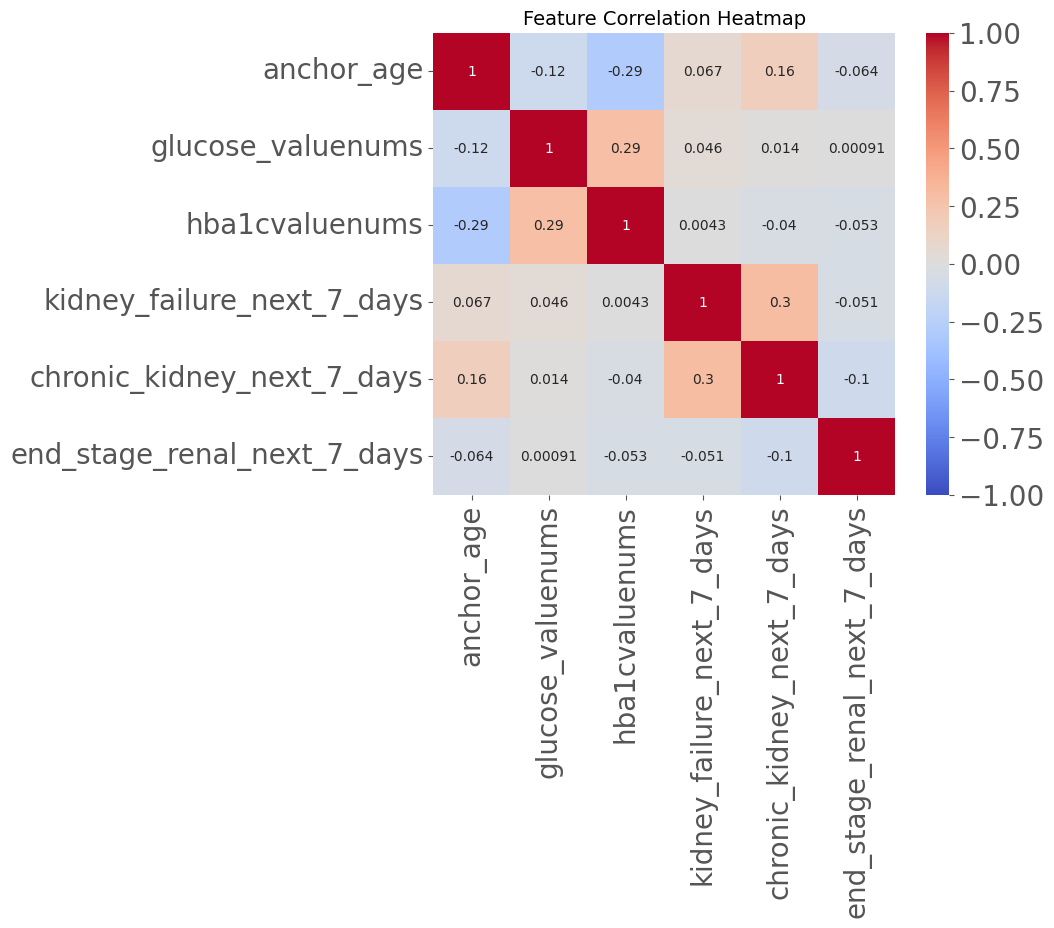

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation
corr = data[['anchor_age', 'glucose_valuenums', 'hba1cvaluenums', 'kidney_failure_next_7_days', 'chronic_kidney_next_7_days', 'end_stage_renal_next_7_days']].corr()

# correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, annot_kws={"size": 10})
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.show()


In [ ]:
X = pd.get_dummies(data[['anchor_age', 'gender']], drop_first=True)
y1 = data['kidney_failure_next_7_days']
y2 = data['chronic_kidney_next_7_days']
y3 = data['end_stage_renal_next_7_days']

# data split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=90089)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=90089)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y3, test_size=0.2, random_state=90089)

# Apply SMOTE
smote = SMOTE(random_state=90089)
X_resampled1, y_resampled1 = smote.fit_resample(X_train1, y_train1)
X_resampled2, y_resampled2 = smote.fit_resample(X_train2, y_train2)
X_resampled3, y_resampled3 = smote.fit_resample(X_train3, y_train3)

## RuotongZhao's Part

### Logistic Regression

In [ ]:
# logistic regression
model1_lr = LogisticRegression(class_weight='balanced', max_iter=10000)
model1_lr.fit(X_resampled1, y_resampled1)

# Predictions
y_pred1 = model1_lr.predict(X_test1)

# Evaluation
print(classification_report(y_test1, y_pred1))
print(f"ROC AUC Score: {roc_auc_score(y_test1, y_pred1)}")

              precision    recall  f1-score   support

           0       0.78      0.52      0.62      1142
           1       0.27      0.55      0.36       363

    accuracy                           0.53      1505
   macro avg       0.53      0.54      0.49      1505
weighted avg       0.66      0.53      0.56      1505

ROC AUC Score: 0.5351782431865222


In [ ]:
# logistic regression
model2_lr = LogisticRegression(class_weight='balanced', max_iter=10000)
model2_lr.fit(X_resampled2, y_resampled2)

# Predictions
y_pred2 = model2_lr.predict(X_test2)

# Evaluation
print(classification_report(y_test2, y_pred2))
print(f"ROC AUC Score: {roc_auc_score(y_test2, y_pred2)}")

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1193
           1       0.27      0.60      0.37       312

    accuracy                           0.58      1505
   macro avg       0.55      0.58      0.52      1505
weighted avg       0.72      0.58      0.62      1505

ROC AUC Score: 0.5830727319620865


In [ ]:
# logistic regression
model3_lr = LogisticRegression(class_weight='balanced', max_iter=10000)
model3_lr.fit(X_resampled3, y_resampled3)

# Predictions
y_pred3 = model3_lr.predict(X_test3)

# Evaluation
print(classification_report(y_test3, y_pred3))
print(f"ROC AUC Score: {roc_auc_score(y_test3, y_pred3)}")

              precision    recall  f1-score   support

           0       0.98      0.58      0.72      1450
           1       0.05      0.62      0.10        55

    accuracy                           0.58      1505
   macro avg       0.51      0.60      0.41      1505
weighted avg       0.94      0.58      0.70      1505

ROC AUC Score: 0.5966771159874609


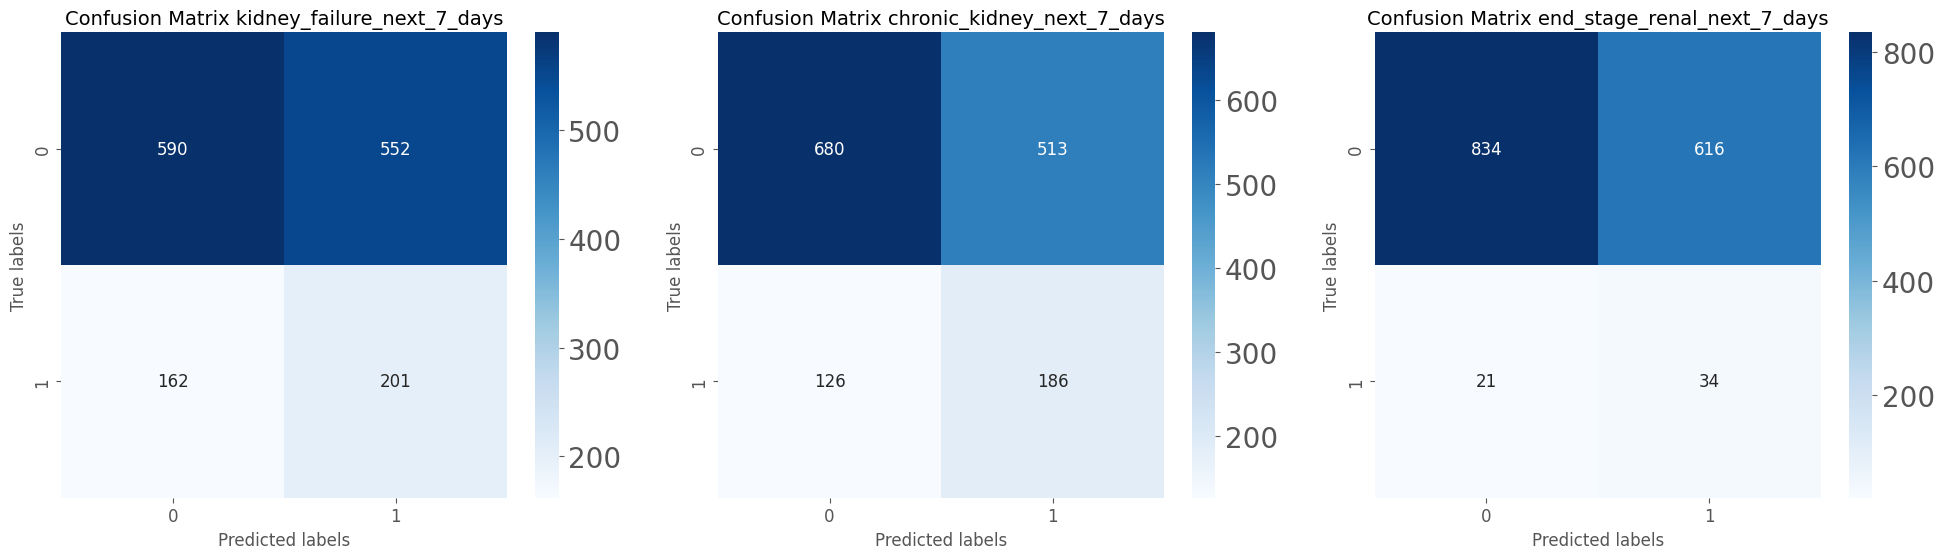

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm1 = confusion_matrix(y_test1, y_pred1)
cm2 = confusion_matrix(y_test2, y_pred2)
cm3 = confusion_matrix(y_test3, y_pred3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.heatmap(cm1, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix kidney_failure_next_7_days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(cm2, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix chronic_kidney_next_7_days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(cm3, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix end_stage_renal_next_7_days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()


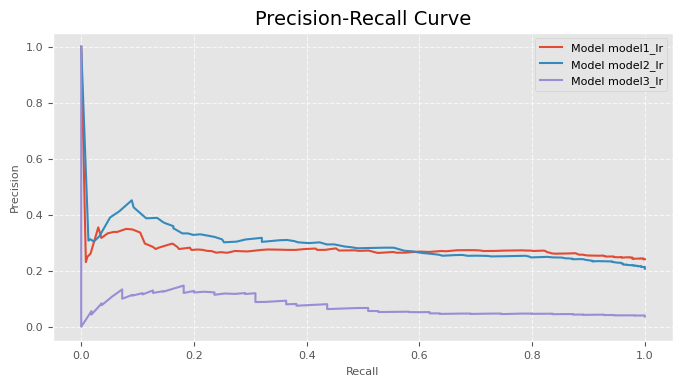

In [ ]:
# precision_recall_curve
from sklearn.metrics import precision_recall_curve

precision1, recall1, thresholds1 = precision_recall_curve(y_test1, model1_lr.predict_proba(X_test1)[:,1])
precision2, recall2, thresholds2 = precision_recall_curve(y_test2, model2_lr.predict_proba(X_test2)[:,1])
precision3, recall3, thresholds3 = precision_recall_curve(y_test3, model3_lr.predict_proba(X_test3)[:,1])

plt.figure(figsize=(8,4))

plt.plot(recall1, precision1, label='Model model1_lr')
plt.plot(recall2, precision2, label='Model model2_lr')
plt.plot(recall3, precision3, label='Model model3_lr')

plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.show()


### Support Vector Classification
SVC is a specific application of SVM for classification tasks

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_resampled1)
X_test_scaled1 = scaler.transform(X_test1)


svc_classifier1 = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=90086)
svc_classifier1.fit(X_train_scaled1, y_resampled1)

y_pred_svc1 = svc_classifier1.predict(X_test_scaled1)
print("SVC Classifier Performance:")
print(classification_report(y_test1, y_pred_svc1))
print("ROC AUC Score:", roc_auc_score(y_test1, y_pred_svc1))


SVC Classifier Performance:
              precision    recall  f1-score   support

           0       0.76      0.45      0.56      1116
           1       0.27      0.59      0.37       385

    accuracy                           0.48      1501
   macro avg       0.51      0.52      0.47      1501
weighted avg       0.63      0.48      0.51      1501

ROC AUC Score: 0.5183715030489224


In [ ]:
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_resampled2)
X_test_scaled2 = scaler.transform(X_test2)


svc_classifier2 = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=90086)
svc_classifier2.fit(X_train_scaled2, y_resampled2)

y_pred_svc2 = svc_classifier2.predict(X_test_scaled2)
print("SVC Classifier Performance:")
print(classification_report(y_test2, y_pred_svc2))
print("ROC AUC Score:", roc_auc_score(y_test2, y_pred_svc2))

SVC Classifier Performance:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67      1182
           1       0.29      0.67      0.40       319

    accuracy                           0.57      1501
   macro avg       0.57      0.61      0.54      1501
weighted avg       0.74      0.57      0.61      1501

ROC AUC Score: 0.6088134981886076


In [ ]:
scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_resampled3)
X_test_scaled3 = scaler.transform(X_test3)


svc_classifier3 = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=90086)
svc_classifier3.fit(X_train_scaled3, y_resampled3)

y_pred_svc3 = svc_classifier3.predict(X_test_scaled3)
print("SVC Classifier Performance:")
print(classification_report(y_test3, y_pred_svc3))
print("ROC AUC Score:", roc_auc_score(y_test3, y_pred_svc3))

SVC Classifier Performance:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1442
           1       0.04      0.42      0.07        59

    accuracy                           0.57      1501
   macro avg       0.50      0.50      0.40      1501
weighted avg       0.92      0.57      0.70      1501

ROC AUC Score: 0.5020863207879828


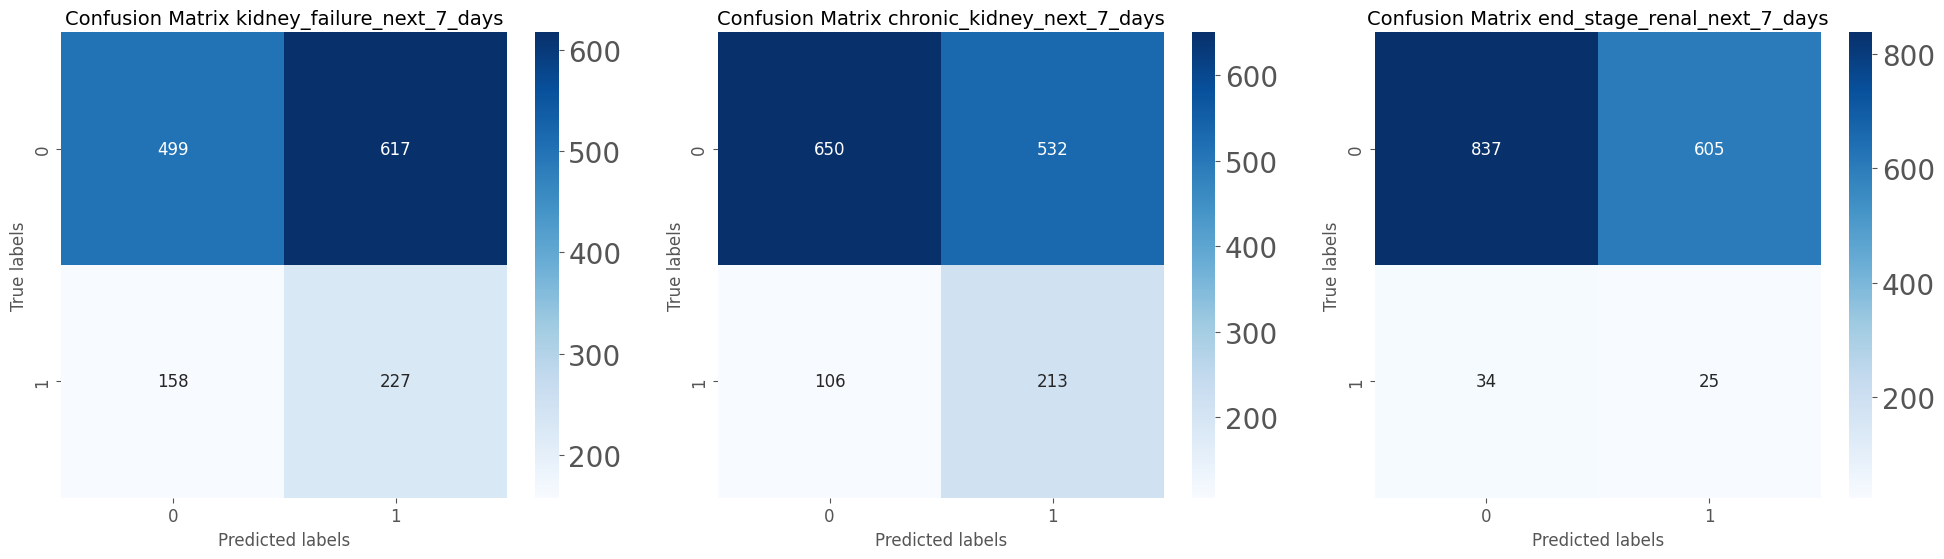

In [ ]:
# Confusion Matrix
cm1_csv = confusion_matrix(y_test1, y_pred_svc1)
cm2_csv = confusion_matrix(y_test2, y_pred_svc2)
cm3_csv = confusion_matrix(y_test3, y_pred_svc3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.heatmap(cm1_csv, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix kidney_failure_next_7_days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(cm2_csv, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix chronic_kidney_next_7_days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(cm3_csv, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix end_stage_renal_next_7_days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()

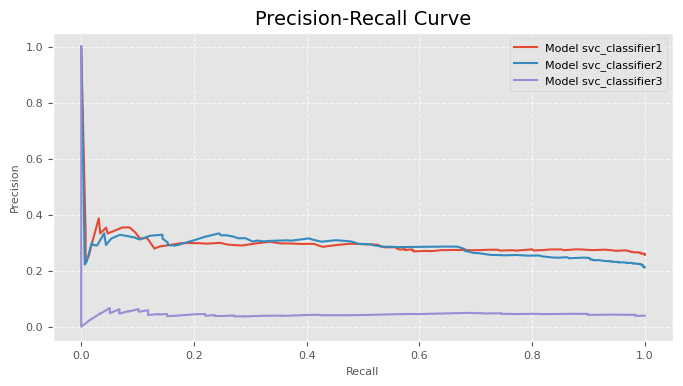

In [ ]:
# precision_recall_curve
precision1, recall1, thresholds1 = precision_recall_curve(y_test1, svc_classifier1.predict_proba(X_test_scaled1)[:,1])
precision2, recall2, thresholds2 = precision_recall_curve(y_test2, svc_classifier2.predict_proba(X_test_scaled2)[:,1])
precision3, recall3, thresholds3 = precision_recall_curve(y_test3, svc_classifier3.predict_proba(X_test_scaled3)[:,1])

plt.figure(figsize=(8,4))

plt.plot(recall1, precision1, label='Model svc_classifier1')
plt.plot(recall2, precision2, label='Model svc_classifier2')
plt.plot(recall3, precision3, label='Model svc_classifier3')

plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.show()

### GRU

With only two features and no time series dimension, GRUs or other recurrent neural networks may not be the best choice unless you have a specific reason for wanting to use them.

In [ ]:
print(X_resampled1.shape)
print(y_resampled1.shape)


(8908, 2)
(8908,)


### Dense Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

Epoch 1/15
140/140 [==============================] - 2s 6ms/step - loss: 0.7730 - accuracy: 0.5054 - val_loss: 0.6891 - val_accuracy: 0.4837
Epoch 2/15
140/140 [==============================] - 1s 4ms/step - loss: 0.7170 - accuracy: 0.5021 - val_loss: 0.7109 - val_accuracy: 0.3304
Epoch 3/15
140/140 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5052 - val_loss: 0.8401 - val_accuracy: 0.2565
Epoch 4/15
140/140 [==============================] - 1s 4ms/step - loss: 0.7070 - accuracy: 0.5054 - val_loss: 0.5969 - val_accuracy: 0.7435
Epoch 5/15
140/140 [==============================] - 1s 4ms/step - loss: 0.7072 - accuracy: 0.5058 - val_loss: 0.8405 - val_accuracy: 0.2645
Epoch 6/15
140/140 [==============================] - 1s 4ms/step - loss: 0.7100 - accuracy: 0.5074 - val_loss: 0.6353 - val_accuracy: 0.7435
Epoch 7/15
140/140 [==============================] - 1s 4ms/step - loss: 0.7009 - accuracy: 0.5111 - val_loss: 0.6444 - val_accuracy: 0.7435
Epoch 

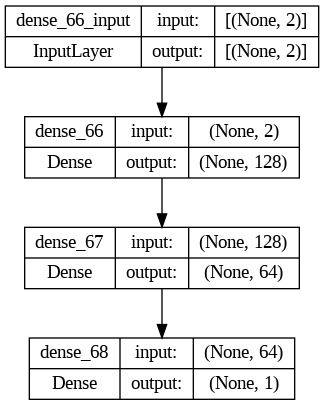

In [ ]:
# Define the model
DNN1 = Sequential()
DNN1.add(Dense(128, activation='relu', input_shape=(2,)))    # The first hidden layer has 128 units
DNN1.add(Dense(64, activation='relu'))                       # Second hidden layer, with 64 units
DNN1.add(Dense(1, activation='sigmoid'))                     # Output layer, suitable for binary classification problems

# Compilation model
DNN1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Training model
DNN1.fit(X_resampled1, y_resampled1, epochs=15, batch_size=64, validation_data=(X_test1, y_test1))

# predict
y_pred_prob1 = DNN1.predict(X_test1)      # This returns the probability that the sample is positive
y_pred1 = (y_pred_prob1 > 0.5).astype(int)  # Use 0.5 as the threshold for binary prediction

# evaluate
print(classification_report(y_test1, y_pred1))
print(f"ROC AUC Score: {roc_auc_score(y_test1, y_pred1)}")

# Generate the image using plot_model, and then display it directly in the notebook using IPython.display
plot_model(DNN1, to_file='temp_model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='temp_model_plot.png'))

In [ ]:
# Define the model
DNN2 = Sequential()
DNN2.add(Dense(128, activation='relu', input_shape=(2,)))    # The first hidden layer has 128 units
DNN2.add(Dense(64, activation='relu'))                       # Second hidden layer, with 64 units
DNN2.add(Dense(1, activation='sigmoid'))                     # Output layer, suitable for binary classification problems

# Compilation model
DNN2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Training model
DNN2.fit(X_resampled2, y_resampled2, epochs=15, batch_size=64, validation_data=(X_test2, y_test2))

# predict
y_pred_prob2 = DNN2.predict(X_test2)      # This returns the probability that the sample is positive
y_pred2 = (y_pred_prob2 > 0.5).astype(int)  # Use 0.5 as the threshold for binary prediction

# evaluate
print(classification_report(y_test2, y_pred2))
print(f"ROC AUC Score: {roc_auc_score(y_test2, y_pred2)}")

Epoch 1/15
148/148 [==============================] - 2s 7ms/step - loss: 0.7303 - accuracy: 0.5103 - val_loss: 0.7284 - val_accuracy: 0.2725
Epoch 2/15
148/148 [==============================] - 1s 7ms/step - loss: 0.7077 - accuracy: 0.5088 - val_loss: 0.5934 - val_accuracy: 0.7875
Epoch 3/15
148/148 [==============================] - 1s 7ms/step - loss: 0.6955 - accuracy: 0.5440 - val_loss: 0.5854 - val_accuracy: 0.7875
Epoch 4/15
148/148 [==============================] - 2s 12ms/step - loss: 0.6904 - accuracy: 0.5428 - val_loss: 0.6553 - val_accuracy: 0.6902
Epoch 5/15
148/148 [==============================] - 2s 12ms/step - loss: 0.6902 - accuracy: 0.5452 - val_loss: 0.5577 - val_accuracy: 0.7875
Epoch 6/15
148/148 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5463 - val_loss: 0.7930 - val_accuracy: 0.3258
Epoch 7/15
148/148 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5550 - val_loss: 0.6986 - val_accuracy: 0.5030
Epoc

In [ ]:
# Define the model
DNN3 = Sequential()
DNN3.add(Dense(128, activation='relu', input_shape=(2,)))    # The first hidden layer has 128 units
DNN3.add(Dense(64, activation='relu'))                       # Second hidden layer, with 64 units
DNN3.add(Dense(1, activation='sigmoid'))                     # Output layer, suitable for binary classification problems

# Compilation model
DNN3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Training model
DNN3.fit(X_resampled3, y_resampled3, epochs=15, batch_size=64, validation_data=(X_test3, y_test3))

# predict
y_pred_prob3 = DNN3.predict(X_test3)      # This returns the probability that the sample is positive
y_pred3 = (y_pred_prob3 > 0.5).astype(int)  # Use 0.5 as the threshold for binary prediction

# evaluate
print(classification_report(y_test3, y_pred3))
print(f"ROC AUC Score: {roc_auc_score(y_test3, y_pred3)}")

Epoch 1/15
181/181 [==============================] - 1s 3ms/step - loss: 0.7217 - accuracy: 0.4990 - val_loss: 0.7125 - val_accuracy: 0.2465
Epoch 2/15
181/181 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5075 - val_loss: 0.5505 - val_accuracy: 0.9227
Epoch 3/15
181/181 [==============================] - 1s 3ms/step - loss: 0.7012 - accuracy: 0.5183 - val_loss: 1.1031 - val_accuracy: 0.0393
Epoch 4/15
181/181 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.5224 - val_loss: 0.5221 - val_accuracy: 0.9127
Epoch 5/15
181/181 [==============================] - 1s 4ms/step - loss: 0.6978 - accuracy: 0.5266 - val_loss: 0.6099 - val_accuracy: 0.7881
Epoch 6/15
181/181 [==============================] - 1s 4ms/step - loss: 0.6991 - accuracy: 0.5361 - val_loss: 0.9516 - val_accuracy: 0.0393
Epoch 7/15
181/181 [==============================] - 1s 3ms/step - loss: 0.6995 - accuracy: 0.5319 - val_loss: 0.7678 - val_accuracy: 0.2052
Epoch 

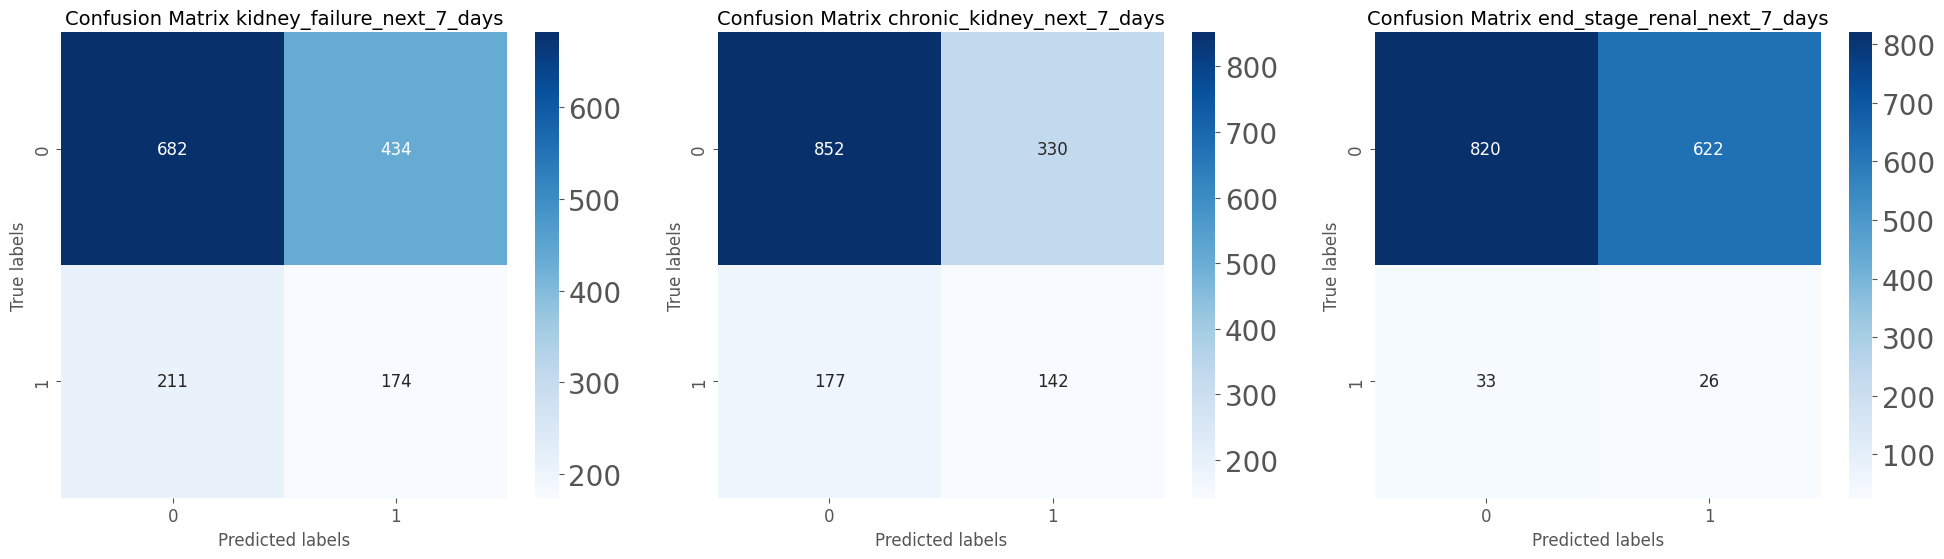

In [ ]:
# Confusion Matrix
conf_matrix1 = confusion_matrix(y_test1, y_pred1)
conf_matrix2 = confusion_matrix(y_test2, y_pred2)
conf_matrix3 = confusion_matrix(y_test3, y_pred3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.heatmap(conf_matrix1, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix kidney_failure_next_7_days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(conf_matrix2, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix chronic_kidney_next_7_days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(conf_matrix3, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix end_stage_renal_next_7_days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()

### Gradient Boosting Trees

focous on recall

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Scale the data
scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_resampled1)
X_test_scaled1 = scaler1.transform(X_test1)

# XGBoost with scikit-learn style
xgb_clf1 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=90086, n_estimators=200)
xgb_clf1.fit(X_train_scaled1, y_resampled1)

# Predict using the trained model
y_pred_prob1 = xgb_clf1.predict_proba(X_test_scaled1)[:,1]
y_pred_xgb1 = [1 if prob > 0.5 else 0 for prob in y_pred_prob1]

# Evaluate the model's performance
print("XGBoost Classifier Performance:")
print(classification_report(y_test1, y_pred_xgb1))
print("ROC AUC Score:", roc_auc_score(y_test1, y_pred_xgb1))

XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.77      0.44      0.56      1116
           1       0.27      0.61      0.38       385

    accuracy                           0.49      1501
   macro avg       0.52      0.53      0.47      1501
weighted avg       0.64      0.49      0.51      1501

ROC AUC Score: 0.5269236140203882


In [ ]:
# Scale the data
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_resampled2)
X_test_scaled2 = scaler2.transform(X_test2)

# XGBoost with scikit-learn style
xgb_clf2 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=90086, n_estimators=200)
xgb_clf2.fit(X_train_scaled2, y_resampled2)

# Predict using the trained model
y_pred_prob2 = xgb_clf2.predict_proba(X_test_scaled2)[:,1]
y_pred_xgb2 = [1 if prob > 0.5 else 0 for prob in y_pred_prob2]

# Evaluate the model's performance
print("XGBoost Classifier Performance:")
print(classification_report(y_test2, y_pred_xgb2))
print("ROC AUC Score:", roc_auc_score(y_test2, y_pred_xgb2))


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.82      0.56      0.67      1182
           1       0.26      0.55      0.35       319

    accuracy                           0.56      1501
   macro avg       0.54      0.56      0.51      1501
weighted avg       0.70      0.56      0.60      1501

ROC AUC Score: 0.558732343565181


In [ ]:
# Scale the data
scaler3 = StandardScaler()
X_train_scaled3 = scaler3.fit_transform(X_resampled3)
X_test_scaled3 = scaler3.transform(X_test3)

# XGBoost with scikit-learn style
xgb_clf3 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=90086, n_estimators=200)
xgb_clf3.fit(X_train_scaled3, y_resampled3)

# Predict using the trained model
y_pred_prob3 = xgb_clf3.predict_proba(X_test_scaled3)[:,1]
y_pred_xgb3 = [1 if prob > 0.5 else 0 for prob in y_pred_prob3]

# Evaluate the model's performance
print("XGBoost Classifier Performance:")
print(classification_report(y_test3, y_pred_xgb3))
print("ROC AUC Score:", roc_auc_score(y_test3, y_pred_xgb3))


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1442
           1       0.04      0.41      0.08        59

    accuracy                           0.61      1501
   macro avg       0.50      0.51      0.41      1501
weighted avg       0.93      0.61      0.73      1501

ROC AUC Score: 0.5126824796069489


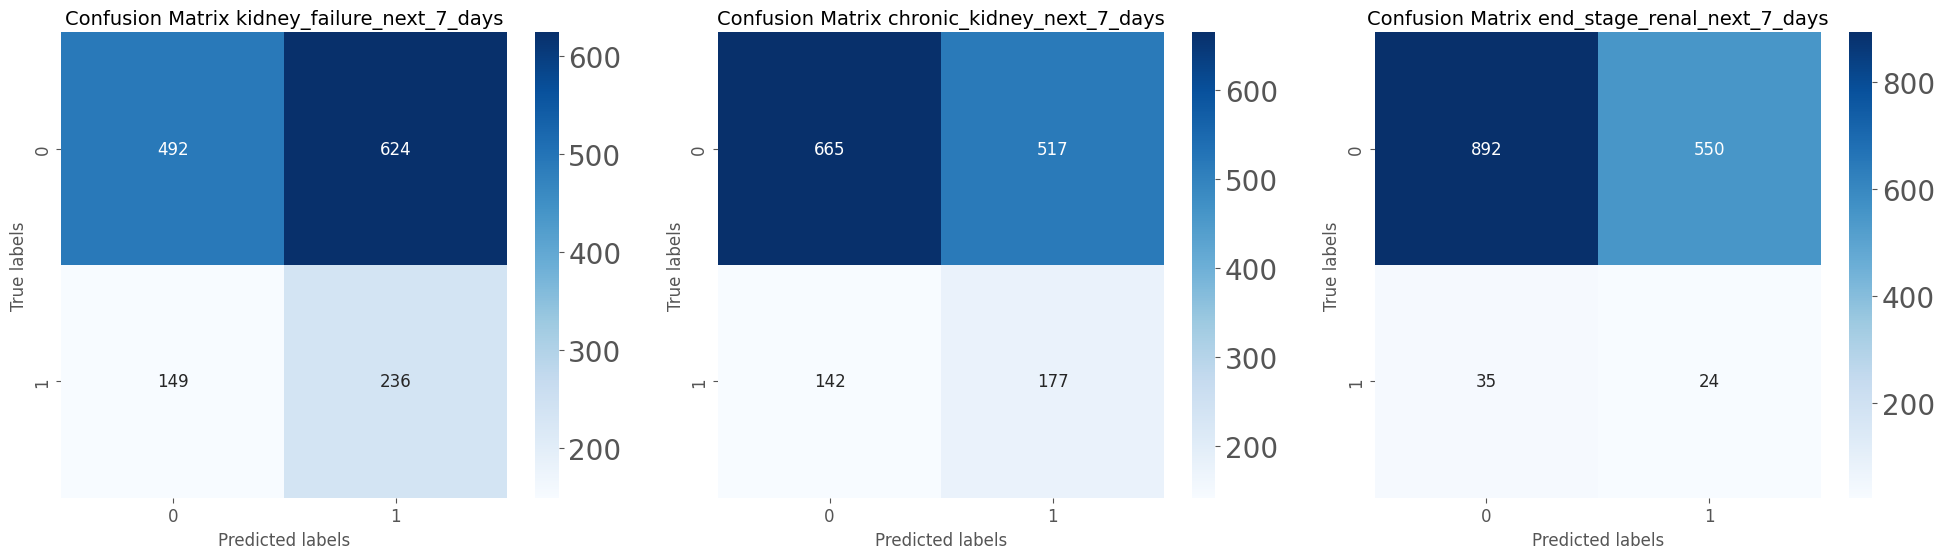

In [ ]:
# Confusion Matrix
GBT_conf_matrix1 = confusion_matrix(y_test1, y_pred_xgb1)
GBT_conf_matrix2 = confusion_matrix(y_test2, y_pred_xgb2)
GBT_conf_matrix3 = confusion_matrix(y_test3, y_pred_xgb3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.heatmap(GBT_conf_matrix1, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix kidney_failure_next_7_days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(GBT_conf_matrix2, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix chronic_kidney_next_7_days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

sns.heatmap(GBT_conf_matrix3, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix end_stage_renal_next_7_days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()

### Stacking

Logistic Regression + SCV
ROC AUC Score: 0.5
It doesn't work well. Same as Random it.

### Voting （Hard）

Sequential models cannot be passed directly to VotingClassifier. (DNN not work there)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# Create the voting classifier
# Hard Voting
hard_voting_clf1 = VotingClassifier(estimators=[
    ('lr', model1_lr),
    ('svc', svc_classifier1),
    ('xgb', xgb_clf1)],
    voting='hard')
hard_voting_clf1.fit(X_resampled1, y_resampled1)

y_pred_hard1 = hard_voting_clf1.predict(X_test1)
print(classification_report(y_test1, y_pred_hard1))
print(f"ROC AUC Score (Hard Voting): {roc_auc_score(y_test1, y_pred_hard1)}")

              precision    recall  f1-score   support

           0       0.78      0.50      0.61      1116
           1       0.29      0.58      0.38       385

    accuracy                           0.52      1501
   macro avg       0.53      0.54      0.50      1501
weighted avg       0.65      0.52      0.55      1501

ROC AUC Score (Hard Voting): 0.5422531769305963


In [ ]:
# Create the voting classifier
# Hard Voting
hard_voting_clf2 = VotingClassifier(estimators=[
    ('lr', model2_lr),
    ('svc', svc_classifier2),
    ('xgb', xgb_clf2)],
    voting='hard')
hard_voting_clf2.fit(X_resampled2, y_resampled2)

y_pred_hard2 = hard_voting_clf2.predict(X_test2)
print(classification_report(y_test2, y_pred_hard2))
print(f"ROC AUC Score (Hard Voting): {roc_auc_score(y_test2, y_pred_hard2)}")

              precision    recall  f1-score   support

           0       0.85      0.57      0.69      1182
           1       0.29      0.63      0.39       319

    accuracy                           0.59      1501
   macro avg       0.57      0.60      0.54      1501
weighted avg       0.73      0.59      0.62      1501

ROC AUC Score (Hard Voting): 0.6034164505195487


In [ ]:
# Create the voting classifier
# Hard Voting
hard_voting_clf3 = VotingClassifier(estimators=[
    ('lr', model3_lr),
    ('svc', svc_classifier3),
    ('xgb', xgb_clf3)],
    voting='hard')
hard_voting_clf3.fit(X_resampled3, y_resampled3)

y_pred_hard3 = hard_voting_clf2.predict(X_test3)
print(classification_report(y_test3, y_pred_hard3))
print(f"ROC AUC Score (Hard Voting): {roc_auc_score(y_test3, y_pred_hard3)}")

              precision    recall  f1-score   support

           0       0.96      0.53      0.68      1442
           1       0.04      0.44      0.07        59

    accuracy                           0.52      1501
   macro avg       0.50      0.48      0.37      1501
weighted avg       0.92      0.52      0.66      1501

ROC AUC Score (Hard Voting): 0.48455534920896115


## Abylaikhan's part


### LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score

# Split data into training and testing sets for all three targets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled1, y_resampled1, test_size=0.2, random_state=90089)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled2, y_resampled2, test_size=0.2, random_state=90089)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_resampled3, y_resampled3, test_size=0.2, random_state=90089)

# Normalize data using Min-Max scaling for all three targets
scaler1 = MinMaxScaler()
X_train1 = scaler1.fit_transform(X_train1)
X_test1 = scaler1.transform(X_test1)

scaler2 = MinMaxScaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

scaler3 = MinMaxScaler()
X_train3 = scaler3.fit_transform(X_train3)
X_test3 = scaler3.transform(X_test3)

# Reshape the data to fit the LSTM for all three targets
X_train1 = X_train1.reshape(X_train1.shape[0], 1, X_train1.shape[1])
X_test1 = X_test1.reshape(X_test1.shape[0], 1, X_test1.shape[1])

X_train2 = X_train2.reshape(X_train2.shape[0], 1, X_train2.shape[1])
X_test2 = X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1])

X_train3 = X_train3.reshape(X_train3.shape[0], 1, X_train3.shape[1])
X_test3 = X_test3.reshape(X_test3.shape[0], 1, X_test3.shape[1])

# LSTM model for kidney_failure_next_7_days
model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_train1.shape[1], X_train1.shape[2])))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train1, y_train1, epochs=20, batch_size=32, validation_data=(X_test1, y_test1))
y_pred1 = model1.predict(X_test1)
y_pred_binary1 = (y_pred1 > 0.5).astype(int)

# LSTM model for chronic_kidney_next_7_days
model2 = Sequential()
model2.add(LSTM(units=50, activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2])))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train2, y_train2, epochs=20, batch_size=32, validation_data=(X_test2, y_test2))
y_pred2 = model2.predict(X_test2)
y_pred_binary2 = (y_pred2 > 0.5).astype(int)

# LSTM model for end_stage_renal_next_7_days
model3 = Sequential()
model3.add(LSTM(units=50, activation='relu', input_shape=(X_train3.shape[1], X_train3.shape[2])))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train3, y_train3, epochs=20, batch_size=32, validation_data=(X_test3, y_test3))
y_pred3 = model3.predict(X_test3)
y_pred_binary3 = (y_pred3 > 0.5).astype(int)

# Display classification reports and ROC AUC scores for all three targets
print("Classification Report for Kidney Failure Next 7 Days:")
print(classification_report(y_test1, y_pred_binary1))
print(f"ROC AUC Score: {roc_auc_score(y_test1, y_pred1)}")

print("Classification Report for Chronic Kidney Next 7 Days:")
print(classification_report(y_test2, y_pred_binary2))
print(f"ROC AUC Score: {roc_auc_score(y_test2, y_pred2)}")

print("Classification Report for End Stage Renal Next 7 Days:")
print(classification_report(y_test3, y_pred_binary3))
print(f"ROC AUC Score: {roc_auc_score(y_test3, y_pred3)}")


Epoch 1/20
223/223 [==============================] - 3s 4ms/step - loss: 0.6931 - accuracy: 0.4950 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 2/20
223/223 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5106 - val_loss: 0.6926 - val_accuracy: 0.5211
Epoch 3/20
223/223 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6924 - val_accuracy: 0.5194
Epoch 4/20
223/223 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.5283 - val_loss: 0.6935 - val_accuracy: 0.5132
Epoch 5/20
223/223 [==============================] - 1s 4ms/step - loss: 0.6918 - accuracy: 0.5275 - val_loss: 0.6922 - val_accuracy: 0.5166
Epoch 6/20
223/223 [==============================] - 1s 6ms/step - loss: 0.6915 - accuracy: 0.5264 - val_loss: 0.6918 - val_accuracy: 0.5216
Epoch 7/20
223/223 [==============================] - 1s 5ms/step - loss: 0.6913 - accuracy: 0.5300 - val_loss: 0.6923 - val_accuracy: 0.5132
Epoch 

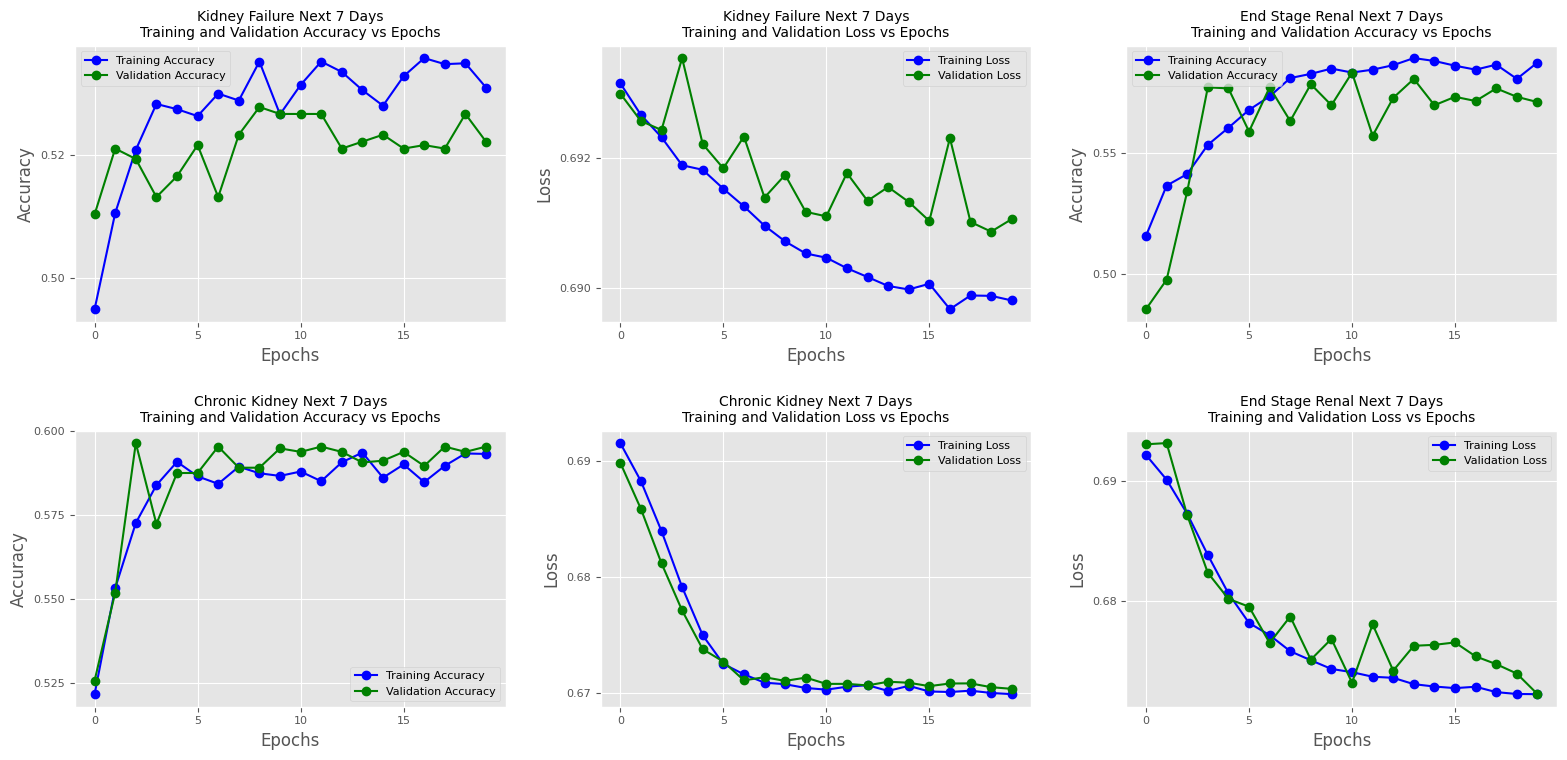

In [ ]:
plt.figure(figsize=(16, 8), facecolor='white')

# Plot Training and Validation Accuracy for Kidney Failure Next 7 Days
plt.subplot(2, 3, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.title('Kidney Failure Next 7 Days\nTraining and Validation Accuracy vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Plot Training and Validation Loss for Kidney Failure Next 7 Days
plt.subplot(2, 3, 2)
plt.plot(history1.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history1.history['val_loss'], label='Validation Loss', color='green', marker='o')
plt.title('Kidney Failure Next 7 Days\nTraining and Validation Loss vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Plot Training and Validation Accuracy for Chronic Kidney Next 7 Days
plt.subplot(2, 3, 4)
plt.plot(history2.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.title('Chronic Kidney Next 7 Days\nTraining and Validation Accuracy vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Plot Training and Validation Loss for Chronic Kidney Next 7 Days
plt.subplot(2, 3, 5)
plt.plot(history2.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='green', marker='o')
plt.title('Chronic Kidney Next 7 Days\nTraining and Validation Loss vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Plot Training and Validation Accuracy for End Stage Renal Next 7 Days
plt.subplot(2, 3, 3)
plt.plot(history3.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.title('End Stage Renal Next 7 Days\nTraining and Validation Accuracy vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Plot Training and Validation Loss for End Stage Renal Next 7 Days
plt.subplot(2, 3, 6)
plt.plot(history3.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history3.history['val_loss'], label='Validation Loss', color='green', marker='o')
plt.title('End Stage Renal Next 7 Days\nTraining and Validation Loss vs Epochs', fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


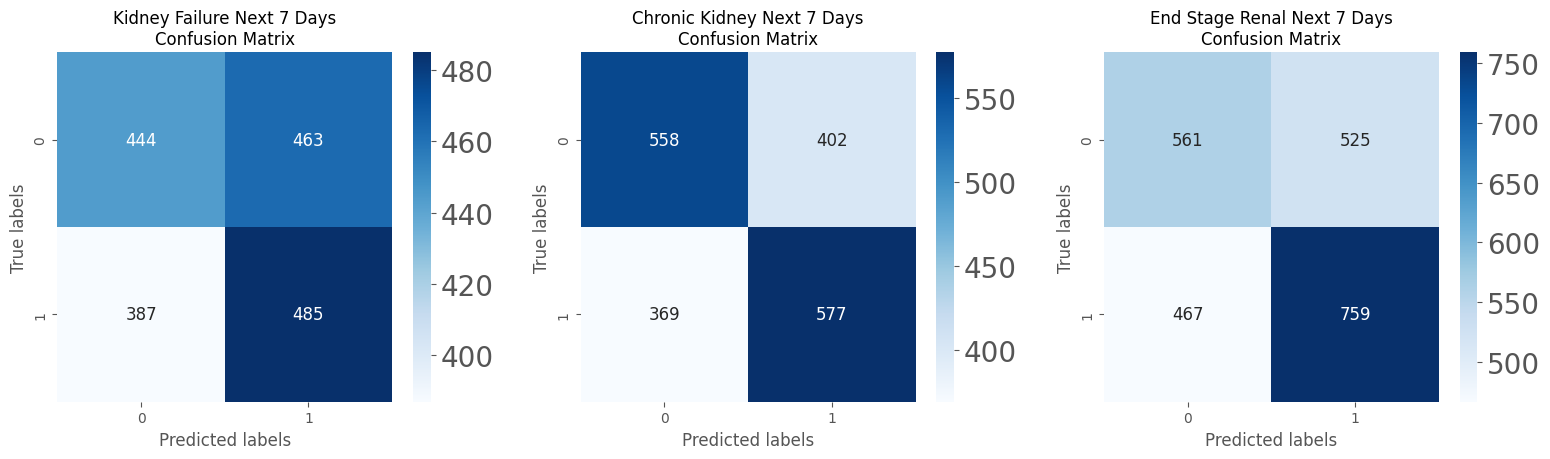

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrices for all three targets
cm1 = confusion_matrix(y_test1, y_pred_binary1)
cm2 = confusion_matrix(y_test2, y_pred_binary2)
cm3 = confusion_matrix(y_test3, y_pred_binary3)

# Plot confusion matrices
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Kidney Failure Next 7 Days\nConfusion Matrix', fontsize=12)
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 3, 2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Chronic Kidney Next 7 Days\nConfusion Matrix', fontsize=12)
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 3, 3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('End Stage Renal Next 7 Days\nConfusion Matrix', fontsize=12)
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


### RNN

In [ ]:
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import classification_report, roc_auc_score

# Define a function to create and train an RNN model
def train_rnn_model(X_train, y_train, X_test, y_test, target_name):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    print(f"Classification Report for {target_name}:")
    print(classification_report(y_test, y_pred_binary))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")

# Train the RNN models for all three targets
train_rnn_model(X_train1, y_train1, X_test1, y_test1, "Kidney Failure Next 7 Days")
train_rnn_model(X_train2, y_train2, X_test2, y_test2, "Chronic Kidney Next 7 Days")
train_rnn_model(X_train3, y_train3, X_test3, y_test3, "End Stage Renal Next 7 Days")


Epoch 1/20
223/223 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5145 - val_loss: 0.6922 - val_accuracy: 0.5160
Epoch 2/20
223/223 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5269 - val_loss: 0.6919 - val_accuracy: 0.5160
Epoch 3/20
223/223 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5279 - val_loss: 0.6917 - val_accuracy: 0.5239
Epoch 4/20
223/223 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5209 - val_loss: 0.6916 - val_accuracy: 0.5233
Epoch 5/20
223/223 [==============================] - 1s 3ms/step - loss: 0.6906 - accuracy: 0.5272 - val_loss: 0.6911 - val_accuracy: 0.5233
Epoch 6/20
223/223 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5262 - val_loss: 0.6925 - val_accuracy: 0.5132
Epoch 7/20
223/223 [==============================] - 1s 2ms/step - loss: 0.6903 - accuracy: 0.5339 - val_loss: 0.6908 - val_accuracy: 0.5211
Epoch 

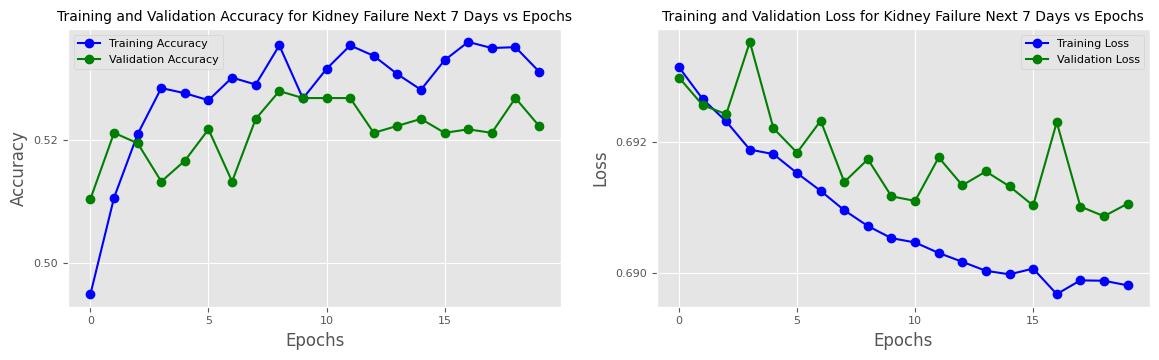

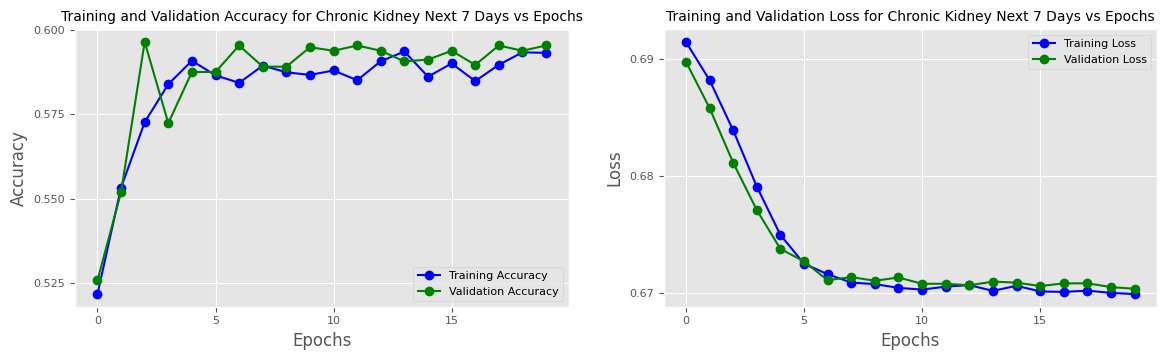

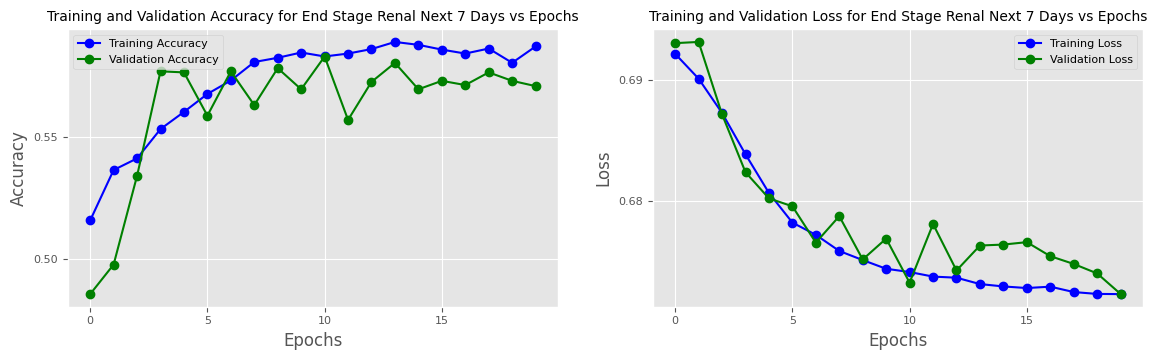

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_training_history(history, target_name):
    plt.figure(figsize=(12, 4), facecolor='white')

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
    plt.title(f'Training and Validation Accuracy for {target_name} vs Epochs', fontsize=10)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green', marker='o')
    plt.title(f'Training and Validation Loss for {target_name} vs Epochs', fontsize=10)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

# Plot training history for all three targets
plot_training_history(history1, "Kidney Failure Next 7 Days")
plot_training_history(history2, "Chronic Kidney Next 7 Days")
plot_training_history(history3, "End Stage Renal Next 7 Days")


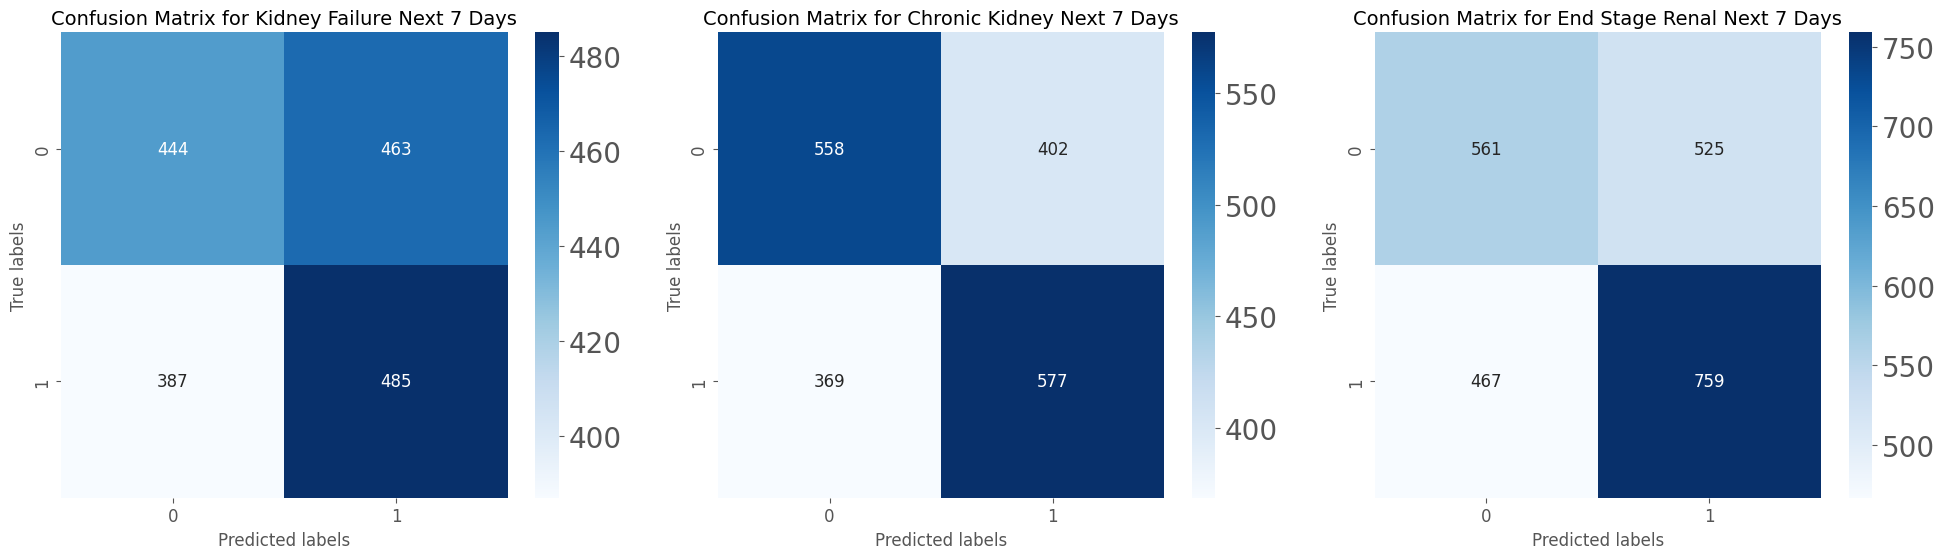

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrices for all three targets
confusion1 = confusion_matrix(y_test1, y_pred_binary1)
confusion2 = confusion_matrix(y_test2, y_pred_binary2)
confusion3 = confusion_matrix(y_test3, y_pred_binary3)

# Create subplots for the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Plot confusion matrix 1
sns.heatmap(confusion1, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix for Kidney Failure Next 7 Days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot confusion matrix 2
sns.heatmap(confusion2, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix for Chronic Kidney Next 7 Days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot confusion matrix 3
sns.heatmap(confusion3, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix for End Stage Renal Next 7 Days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


### Random forest

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


X1 = X_resampled1  # Features for kidney_failure_next_7_days
X2 = X_resampled2  # Features for chronic_kidney_next_7_days
X3 = X_resampled3  # Features for end_stage_renal_next_7_days
y1 = y_resampled1  # Target for kidney_failure_next_7_days
y2 = y_resampled2  # Target for chronic_kidney_next_7_days
y3 = y_resampled3  # Target for end_stage_renal_next_7_days

rf_classifier1 = RandomForestClassifier(n_estimators=100, random_state=90089)
rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=90089)
rf_classifier3 = RandomForestClassifier(n_estimators=100, random_state=90089)


rf_classifier1.fit(X1, y1)
rf_classifier2.fit(X2, y2)
rf_classifier3.fit(X3, y3)


print("Metrics for Kidney Failure Next 7 Days:")
y_pred1 = rf_classifier1.predict(X_test1)
report1 = classification_report(y_test1, y_pred1)
roc_auc1 = roc_auc_score(y_test1, y_pred1)
print(f"Classification Report for Kidney Failure Next 7 Days:\n{report1}\n")
print(f"ROC AUC Score for Kidney Failure Next 7 Days: {roc_auc1}\n")

print("Metrics for Chronic Kidney Next 7 Days:")
y_pred2 = rf_classifier2.predict(X_test2)
report2 = classification_report(y_test2, y_pred2)
roc_auc2 = roc_auc_score(y_test2, y_pred2)
print(f"Classification Report for Chronic Kidney Next 7 Days:\n{report2}\n")
print(f"ROC AUC Score for Chronic Kidney Next 7 Days: {roc_auc2}\n")

print("Metrics for End Stage Renal Next 7 Days:")
y_pred3 = rf_classifier3.predict(X_test3)
report3 = classification_report(y_test3, y_pred3)
roc_auc3 = roc_auc_score(y_test3, y_pred3)
print(f"Classification Report for End Stage Renal Next 7 Days:\n{report3}\n")
print(f"ROC AUC Score for End Stage Renal Next 7 Days: {roc_auc3}\n")


Metrics for Kidney Failure Next 7 Days:
Classification Report for Kidney Failure Next 7 Days:
              precision    recall  f1-score   support

           0       0.78      0.48      0.60      1142
           1       0.26      0.58      0.36       363

    accuracy                           0.50      1505
   macro avg       0.52      0.53      0.48      1505
weighted avg       0.66      0.50      0.54      1505


ROC AUC Score for Kidney Failure Next 7 Days: 0.531940966744342

Metrics for Chronic Kidney Next 7 Days:
Classification Report for Chronic Kidney Next 7 Days:
              precision    recall  f1-score   support

           0       0.84      0.53      0.65      1193
           1       0.26      0.62      0.36       312

    accuracy                           0.55      1505
   macro avg       0.55      0.57      0.51      1505
weighted avg       0.72      0.55      0.59      1505


ROC AUC Score for Chronic Kidney Next 7 Days: 0.5734089883293572

Metrics for End Stage Ren

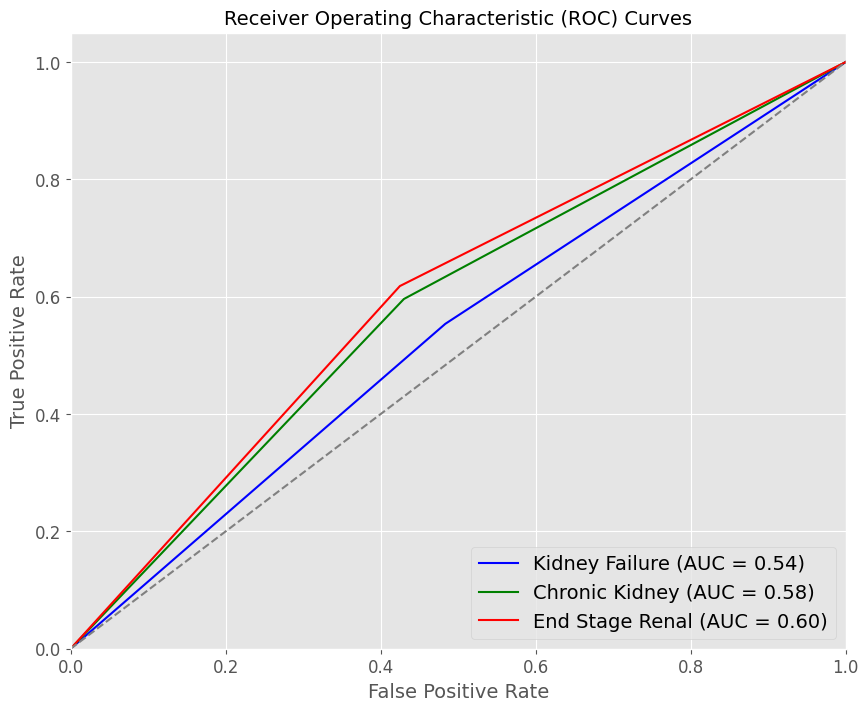

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# ROC Curve for Kidney Failure Next 7 Days
fpr1, tpr1, _ = roc_curve(y_test1, y_pred1)
roc_auc_val1 = auc(fpr1, tpr1)

# ROC Curve for Chronic Kidney Next 7 Days
fpr2, tpr2, _ = roc_curve(y_test2, y_pred2)
roc_auc_val2 = auc(fpr2, tpr2)

# ROC Curve for End Stage Renal Next 7 Days
fpr3, tpr3, _ = roc_curve(y_test3, y_pred3)
roc_auc_val3 = auc(fpr3, tpr3)

plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='blue', label=f'Kidney Failure (AUC = {roc_auc_val1:.2f})')
plt.plot(fpr2, tpr2, color='green', label=f'Chronic Kidney (AUC = {roc_auc_val2:.2f})')
plt.plot(fpr3, tpr3, color='red', label=f'End Stage Renal (AUC = {roc_auc_val3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize = 14)
plt.legend(loc="lower right", fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


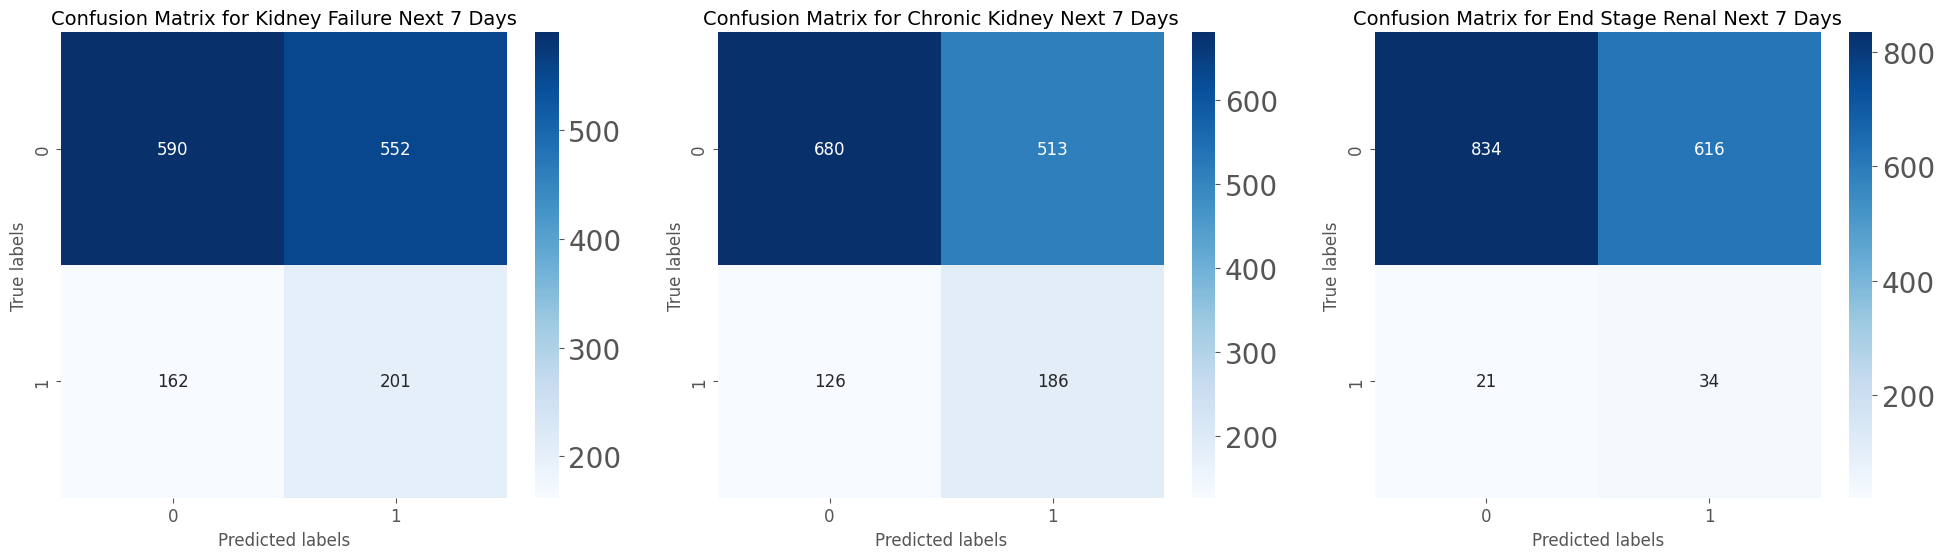

In [ ]:
confusion1 = confusion_matrix(y_test1, y_pred1)
confusion2 = confusion_matrix(y_test2, y_pred2)
confusion3 = confusion_matrix(y_test3, y_pred3)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Plot confusion matrix 1
sns.heatmap(confusion1, annot=True, fmt='g', cmap='Blues', ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Confusion Matrix for Kidney Failure Next 7 Days', fontsize=14)
axes[0].set_xlabel('Predicted labels', fontsize=12)
axes[0].set_ylabel('True labels', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot confusion matrix 2
sns.heatmap(confusion2, annot=True, fmt='g', cmap='Blues', ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Confusion Matrix for Chronic Kidney Next 7 Days', fontsize=14)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot confusion matrix 3
sns.heatmap(confusion3, annot=True, fmt='g', cmap='Blues', ax=axes[2], annot_kws={"size": 12})
axes[2].set_title('Confusion Matrix for End Stage Renal Next 7 Days', fontsize=14)
axes[2].set_xlabel('Predicted labels', fontsize=12)
axes[2].set_ylabel('True labels', fontsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

### Random forest improving trials

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=90089),
                               param_distributions=param_grid,
                               scoring='f1',
                               n_iter=100,
                               cv=StratifiedKFold(n_splits=3),
                               verbose=2,
                               random_state=90089,
                               n_jobs=-1)


scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.transform(X2)
X3_scaled = scaler.transform(X3)

# ADASYN
adasyn = ADASYN(random_state=42)
X_resampled1, y_resampled1 = adasyn.fit_resample(X1_scaled, y1)
X_resampled2, y_resampled2 = adasyn.fit_resample(X2_scaled, y2)
X_resampled3, y_resampled3 = adasyn.fit_resample(X3_scaled, y3)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'nthread': -1,
    'use_label_encoder': False
}

xgb_classifier1 = xgb.XGBClassifier(**xgb_params)
xgb_classifier1.fit(X_resampled1, y_resampled1)
xgb_classifier2 = xgb.XGBClassifier(**xgb_params)
xgb_classifier2.fit(X_resampled2, y_resampled2)
xgb_classifier3 = xgb.XGBClassifier(**xgb_params)
xgb_classifier3.fit(X_resampled3, y_resampled3)

# Cost-sensitive Learning
weights = {0: 1, 1: 5}
rf_classifier_weighted1 = RandomForestClassifier(class_weight=weights)
rf_classifier_weighted1.fit(X_resampled1, y_resampled1)
rf_classifier_weighted2 = RandomForestClassifier(class_weight=weights)
rf_classifier_weighted2.fit(X_resampled2, y_resampled2)
rf_classifier_weighted3 = RandomForestClassifier(class_weight=weights)
rf_classifier_weighted3.fit(X_resampled3, y_resampled3)

# Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    avg_prec = average_precision_score(y_test, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"Classification Report for {model_name}:\n{report}\n")
    print(f"ROC AUC Score for {model_name}: {roc_auc}\n")
    print(f"Average Precision Score for {model_name}: {avg_prec}\n")


# Evaluate Random Forest models
evaluate_model(rf_classifier_weighted1, X_test1, y_test1, "Kidney Failure Next 7 Days - RF")
evaluate_model(rf_classifier_weighted2, X_test2, y_test2, "Chronic Kidney Next 7 Days - RF")
evaluate_model(rf_classifier_weighted3, X_test3, y_test3, "End Stage Renal Next 7 Days - RF")

# Evaluate XGBoost models
evaluate_model(xgb_classifier1, X_test1, y_test1, "Kidney Failure Next 7 Days - XGBoost")
evaluate_model(xgb_classifier2, X_test2, y_test2, "Chronic Kidney Next 7 Days - XGBoost")
evaluate_model(xgb_classifier3, X_test3, y_test3, "End Stage Renal Next 7 Days - XGBoost")

# Feature Importance
feature_importances = rf_classifier_weighted1.feature_importances_
features = list(X1.columns)
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")



Metrics for Kidney Failure Next 7 Days - RF:
Classification Report for Kidney Failure Next 7 Days - RF:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1142
           1       0.24      1.00      0.39       363

    accuracy                           0.24      1505
   macro avg       0.12      0.50      0.19      1505
weighted avg       0.06      0.24      0.09      1505


ROC AUC Score for Kidney Failure Next 7 Days - RF: 0.5

Average Precision Score for Kidney Failure Next 7 Days - RF: 0.24119601328903653

Metrics for Chronic Kidney Next 7 Days - RF:
Classification Report for Chronic Kidney Next 7 Days - RF:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1193
           1       0.21      1.00      0.34       312

    accuracy                           0.21      1505
   macro avg       0.10      0.50      0.17      1505
weighted avg       0.04      0.21      0.07      1505


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import xgboost as xgb
import imblearn

print('Python version:', sys.version)

# Print versions
print('NumPy version:', np.__version__)
print('pandas version:', pd.__version__)
print('matplotlib version:', matplotlib.__version__)
print('seaborn version:', sns.__version__)
print('scikit-learn version:', sklearn.__version__)
print('TensorFlow version:', tf.__version__)
print('XGBoost version:', xgb.__version__)
print('imbalanced-learn version:', imblearn.__version__)


Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
NumPy version: 1.23.5
pandas version: 1.5.3
matplotlib version: 3.7.1
seaborn version: 0.12.2
scikit-learn version: 1.2.2
TensorFlow version: 2.14.0
XGBoost version: 2.0.1
imbalanced-learn version: 0.10.1
